# Creating ImageNet-Captions

This notebook creates embeddings for the ImageNet-Captions dataset for various embedding models: CLIP, BERT, and GPT-2. This dataset is created using a subset of ImageNet images that are from the 50 most frequent classes from the original validation set, with captions retrieved from the original Flickr posts. 

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Retrieve Subset of the Original Training Set

Please see the original [ImageNet-Captions](https://github.com/mlfoundations/imagenet-captions) for background on this dataset. This dataset is specified by a a subset of ImageNet images that whose original source was Flickr; these images are paired with their original captions. We use a subset of this dataset with approximately 200k images. The image filename and caption for each training example are listed in the `data/imagenet_captions_train_c250.csv` file. We assume that the `imagenet_images_flickr` folder exists within the `DATA_PATH` specified below.

In [2]:
NUM_CLASSES = 250
DATA_PATH = f'/mnt/ssd/ronak/datasets/imagenet_captions_{NUM_CLASSES}k' # TODO: Change this to the location on your machine.
DEVICE = 'cuda:0'

In [3]:
train_df = pd.read_csv(f"../data/imagenet_captions_train_c{NUM_CLASSES}.csv", header=0, sep="\t")
val_df = pd.read_csv(f"../data/imagenet_captions_val_c{NUM_CLASSES}.csv", header=0, sep="\t")
class_df = pd.read_csv("../data/map_clsloc.txt", sep=" ", header=None)

class_df.columns = ["directory", "class_idx", "class_name"]
train_df

,title,filepath
0,120-2060_IMG,imagenet_images_flickr/n01871265/229706807.jpg
1,127-2701_IMG,imagenet_images_flickr/n01871265/229749569.jpg
2,Tusker,imagenet_images_flickr/n01871265/48085040.jpg
3,Old Tusker,imagenet_images_flickr/n01871265/2039863126.jpg
4,IMG_0031,imagenet_images_flickr/n01871265/2105099569.jpg
...,...,...
174589,Royal Albatross (Northern),imagenet_images_flickr/n02058221/2362697397.jpg
174590,albatross,imagenet_images_flickr/n02058221/3334244815.jpg
174591,mollymawk 3,imagenet_images_flickr/n02058221/79045502.jpg
174592,Laysan albatross w/ chick,imagenet_images_flickr/n02058221/2517173423.jpg


## Match Classes to Captions

In [4]:
class_df = class_df.set_index("directory")
class_df

,class_idx,class_name
directory,,
n02119789,1,kit_fox
n02100735,2,English_setter
n02110185,3,Siberian_husky
n02096294,4,Australian_terrier
n02102040,5,English_springer
...,...,...
n03063599,996,coffee_mug
n04116512,997,rubber_eraser
n04325704,998,stole


We confirm that the class labels match the folders correctly.

folder n01871265 corresponds to class tusker.


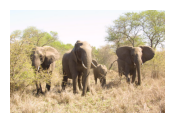

In [5]:
files = list(train_df['filepath'])
files = [os.path.join(DATA_PATH, f) for f in files]
folder = os.path.split(files[0])[0].split("/")[-1]
class_name = class_df.loc[folder]['class_name']

print(f"folder {folder} corresponds to class {class_name}.")


img = mpimg.imread(files[0])

fig, ax = plt.subplots(figsize=(2, 2))
ax.axis("off")
ax.imshow(img)
plt.show()

In [6]:
def add_class_columns(df):
    df['directory'] = df['filepath'].map(lambda x: os.path.split(x)[0].split("/")[-1])
    df['class_name'] = df['directory'].map(lambda x: class_df.loc[x]['class_name'])
    df['class_idx'] = df['directory'].map(lambda x: class_df.loc[x]['class_idx'])
    return df

train_df = add_class_columns(train_df)
val_df = add_class_columns(val_df)

In [10]:
rng = np.random.RandomState(42)
class_order = rng.permutation(np.arange(NUM_CLASSES))

labels = train_df["class_idx"].unique().tolist()
label_to_global = {label: i for i, label in enumerate(labels)}

global_class_df = class_df.loc[class_df["class_idx"].isin(labels)].copy()

train_df["global_label"] = train_df["class_idx"].map(lambda x: class_order[label_to_global[x]])
val_df["global_label"] = val_df["class_idx"].map(lambda x: class_order[label_to_global[x]])
global_class_df["global_label"] = global_class_df["class_idx"].map(lambda x: class_order[label_to_global[x]])

In [11]:
prompt_idx = rng.choice(len(train_df), size=40000, replace=False)
eval_idx = np.delete(np.arange(len(train_df)), prompt_idx)

assert len(np.union1d(prompt_idx, eval_idx)) == len(train_df)
assert len(np.intersect1d(prompt_idx, eval_idx)) == 0

prompt_df = train_df.iloc[prompt_idx]
eval_df = train_df.iloc[eval_idx]

We save a version of the filenames and captions that includes the absolute file path provided above.

In [9]:
train_df.to_csv("../data/train_df.csv", index=False, sep="\t")
val_df.to_csv("../data/val_df.csv", index=False, sep="\t")
prompt_df.to_csv("../data/prompt_df.csv", index=False, sep="\t")
eval_df.to_csv("../data/eval_df.csv", index=False, sep="\t")
global_class_df.to_csv("../data/global_class_df.csv", index=False, sep="\t")

## Query Evaluation Dataset

In [15]:
import open_clip
import sys
sys.path.append("..")

from src.data import ImageClassificationDataset

In [16]:
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

In [18]:
input_filename = "../data/prompt_df.csv"
class_filename = "../data/global_class_df.csv"
transforms = preprocess_val
task_id = 4
n_tasks = 10

dataset = ImageClassificationDataset(input_filename, class_filename, transforms, n_tasks=n_tasks, task_id=task_id)

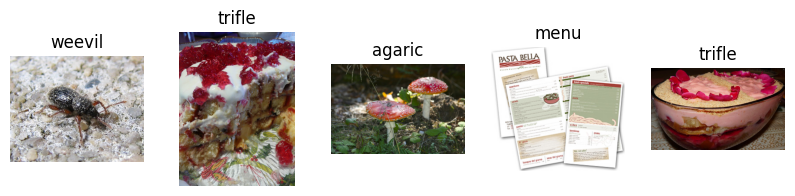

In [20]:
ids = [205, 793, 14, 543, 309]

fig, ax = plt.subplots(1, len(ids), figsize=(2 * len(ids), 2))


for i, idx in enumerate(ids):
    img = mpimg.imread(dataset.images[idx])
    label_name = dataset.class_names[dataset.labels[idx]]
    ax[i].axis("off")
    ax[i].imshow(img)
    ax[i].set_title(label_name)

plt.show()